In [15]:
import numpy as np
import librosa
import librosa.display
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [16]:
SR = 22050
DURATION = 1 # seconds - adjust as needed
N_MELS_SPEC = 128 # Number of Mel bins for the spectrogram
N_FFT_SPEC = 2048 # FFT window size
HOP_LENGTH_MEL_SPEC = 512

In [17]:
ds = glob('mswc_microset/mswc_microset/*/clips/*/*.opus')

In [18]:
file_num_1, file_num_2 = 5, 10

file1_path = ds[file_num_1]
file2_path = ds[file_num_2]

print(f"Processing File 1: {file1_path}")
print(f"Processing File 2: {file2_path}")

y1_mel, sr1_mel = librosa.load(file1_path, sr=SR, duration=DURATION)
y2_mel, sr2_mel = librosa.load(file2_path, sr=SR, duration=DURATION)

# Pad audio if shorter than DURATION
if len(y1_mel) < SR * DURATION:
    y1_mel = np.pad(y1_mel, (0, max(0, int(SR * DURATION) - len(y1_mel))))
if len(y2_mel) < SR * DURATION:
    y2_mel = np.pad(y2_mel, (0, max(0, int(SR * DURATION) - len(y2_mel))))

Processing File 1: mswc_microset/mswc_microset\en\clips\backward\common_voice_en_18854341.opus
Processing File 2: mswc_microset/mswc_microset\en\clips\backward\common_voice_en_19814783.opus


In [19]:
S_mel1 = librosa.feature.melspectrogram(y=y1_mel, sr=sr1_mel, n_fft=N_FFT_SPEC,
                                         hop_length=HOP_LENGTH_MEL_SPEC, n_mels=N_MELS_SPEC)
S_db1 = librosa.power_to_db(S_mel1, ref=np.max)

S_mel2 = librosa.feature.melspectrogram(y=y2_mel, sr=sr2_mel, n_fft=N_FFT_SPEC,
                                         hop_length=HOP_LENGTH_MEL_SPEC, n_mels=N_MELS_SPEC)
S_db2 = librosa.power_to_db(S_mel2, ref=np.max)

n_mels_spec, n_frames1_mel = S_db1.shape
_, n_frames2_mel = S_db2.shape

In [20]:
max_frames_mel = max(n_frames1_mel, n_frames2_mel)
S_db1_padded = np.pad(S_db1, ((0, 0), (0, max_frames_mel - n_frames1_mel)), mode='constant')
S_db2_padded = np.pad(S_db2, ((0, 0), (0, max_frames_mel - n_frames2_mel)), mode='constant')

Saving Mel Spectrogram animation as GIF...
Mel Spectrogram animation saved.


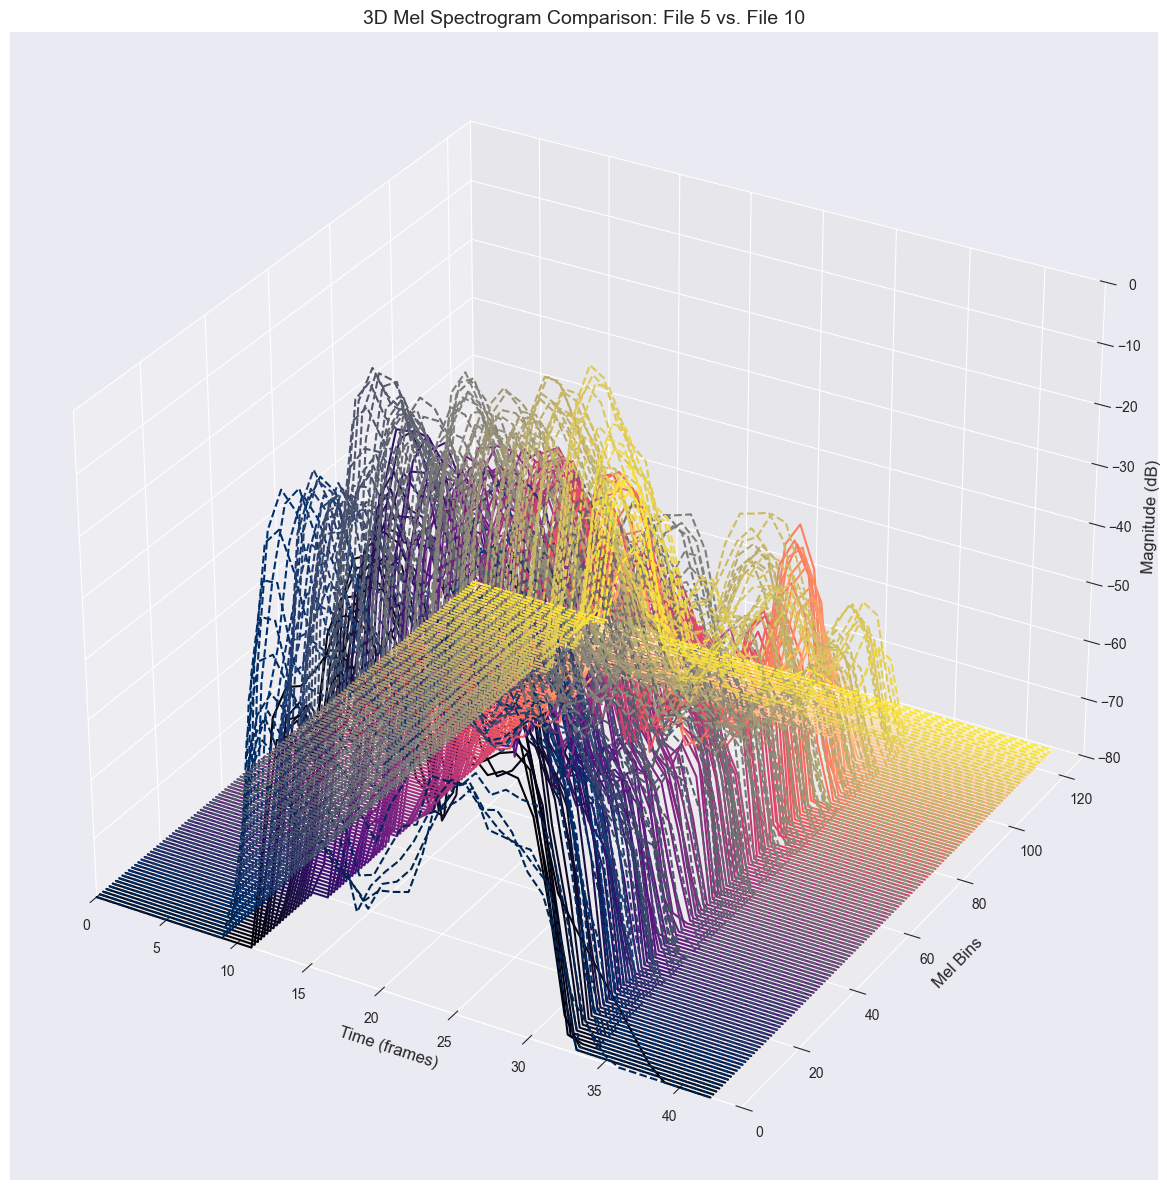

In [21]:
time_mel = np.arange(max_frames_mel)
mel_bins = np.arange(n_mels_spec)

fig_mel = plt.figure(figsize=(18, 12)) # Adjusted figure size
ax_mel = fig_mel.add_subplot(111, projection='3d')

ax_mel.set_xlabel('Time (frames)', fontsize=12)
ax_mel.set_ylabel('Mel Bins', fontsize=12)
ax_mel.set_zlabel('Magnitude (dB)', fontsize=12)
ax_mel.set_title(f'3D Mel Spectrogram Comparison: File {file_num_1} vs. File {file_num_2}', fontsize=14)

# Set axis limits
ax_mel.set_xlim(0, max_frames_mel)
ax_mel.set_ylim(0, n_mels_spec)
ax_mel.set_zlim(min(S_db1_padded.min(), S_db2_padded.min()), max(S_db1_padded.max(), S_db2_padded.max()))

# Create empty lines for each Mel bin for both files
lines1_mel = [ax_mel.plot([], [], [], lw=1.5, color=plt.cm.magma(i / n_mels_spec),
                          label=f'Mel Bin {i+1} (File {file_num_1})')[0] for i in mel_bins]
lines2_mel = [ax_mel.plot([], [], [], lw=1.5, linestyle='--', color=plt.cm.cividis(i / n_mels_spec),
                          label=f'Mel Bin {i+1} (File {file_num_2})')[0] for i in mel_bins]

# Add legend (as with CQT, consider if all labels are needed or a subset)
# ax_mel.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=8)

# Animation function for Mel Spectrogram
def update_mel(frame):
    for i, (line1, line2) in enumerate(zip(lines1_mel, lines2_mel)):
        line1.set_data(time_mel[:frame], np.ones(frame) * i)
        line1.set_3d_properties(S_db1_padded[i, :frame])
        line2.set_data(time_mel[:frame], np.ones(frame) * i)
        line2.set_3d_properties(S_db2_padded[i, :frame])
    return lines1_mel + lines2_mel

# Create and run the animation
ani_mel = FuncAnimation(fig_mel, update_mel, frames=max_frames_mel, interval=50, blit=False)

# Save as GIF (requires `pillow`)
print("Saving Mel Spectrogram animation as GIF...")
ani_mel.save('3d_mel_spec_comparison_animation.gif', writer='pillow', fps=15, dpi=100)
print("Mel Spectrogram animation saved.")

# Alternatively, save as MP4 (requires `ffmpeg`)
# ani_mel.save('bilingual_mel_spec_comparison.mp4', writer='ffmpeg', fps=15)

plt.tight_layout()
plt.show()